# Задание 2: Анализ архитектур CNN

## 2.1 Влияние размера ядра свертки

### Импорты библиотек

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets
import torchvision.transforms.v2 as v2
import numpy as np
import matplotlib.pyplot as plt
import time
from torch.utils.data import DataLoader
from collections import OrderedDict

### Подготовка данных

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 0.01
batch_size = 64
epochs = 15


transform = v2.Compose([
    v2.ToTensor(),
    v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=False, transform=transform)
val_dataset = datasets.CIFAR10(root="./data", train=False, download=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### Модель NN (взял из репозитория HW4)

In [7]:
class CIFARCNN(nn.Module):
    def __init__(self, kernel_sizes: tuple, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=kernel_sizes[0], stride=1, padding=kernel_sizes[0]//2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_sizes[1], stride=1, padding=kernel_sizes[1]//2)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Модель 1x1 + 3x3
class ComboCIFARCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1a = nn.Conv2d(3, 3, kernel_size=1)
        self.conv1b = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        x = torch.relu(self.conv1a(x))
        x = self.pool(torch.relu(self.conv1b(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### Функции визуализации

In [20]:
def visualize_activations(model, val_loader, device, model_name):
    """Функция для создания графиков активаций первого слоя"""
    model.eval()
    dataiter = iter(val_loader)
    images, labels = next(dataiter)
    images = images.to(device)
    
    # Хук для захвата активаций
    activations = {}
    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook
    
    # Регистрируем хук для первого слоя
    if model_name == "1x1 + 3x3":
        model.conv1b.register_forward_hook(get_activation('conv1b'))
    else:
        model.conv1.register_forward_hook(get_activation('conv1'))
    
    with torch.no_grad():
        model(images)
    
    if model_name == "1x1 + 3x3":
        act = activations['conv1b'].cpu()
        title = "1x1 + 3x3 Conv1b активации"
    else:
        act = activations['conv1'].cpu()
        title = f"{model_name} Conv1 Activations"
    
    fig, axes = plt.subplots(4, 8, figsize=(12, 6))
    for i in range(4):
        for j in range(8):
            axes[i, j].imshow(act[0, i*8+j].numpy(), cmap='viridis')
            axes[i, j].axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(f"plots/{model_name}_activations_task_2_1.jpg")
    plt.show()

def plot_accuracy(results):
    """Функция для визуализации метрики точности"""
    plt.figure(figsize=(8, 4))
    for name, res in results.items():
        plt.plot(res['val_accuracy'], label=name)
    plt.title('Валидационная точность')
    plt.xlabel('Эпоха')
    plt.ylabel('Точность (%)')
    plt.savefig(f"plots/val_accuracy_task_2_1.jpg")
    plt.legend()

def plot_train_time(results):
    """Функция для визуализации времени обучения"""
    plt.figure(figsize=(8, 4))
    times = [res['training_time'] for res in results.values()]
    names = list(results.keys())
    plt.bar(names, times, color=['blue', 'orange', 'green', 'red'], edgecolor='black')
    plt.title('Время обучения')
    plt.ylabel('Время (сек)')
    plt.savefig(f"plots/train_time_task_2_1.jpg")
    plt.xticks(rotation=15)

def plot_received_field(results):
    """Функция для визуализации размера рецептивных полей"""
    plt.figure(figsize=(8, 4))
    # plt.subplot(2, 2, 4)
    rf_sizes = [res['receptive_field'] for res in results.values()]
    names = list(results.keys())
    plt.bar(names, rf_sizes, color=['blue', 'orange', 'green', 'red'], edgecolor='black')
    plt.title('Размер рецептивных полей')
    plt.ylabel('Пиксели')
    plt.xticks(rotation=15)
    
    plt.tight_layout()
    plt.savefig(f'plots/comparison_results_task_2_1.jpg')
    plt.show()

### Функция обучения

In [9]:
def calculate_rf(kernel_sizes):
    """Функция для расчета рецептивного поля"""
    rf = 1
    stride_product = 1
    layers = [
        ('conv1', kernel_sizes[0], 1),
        ('pool1', 2, 2),
        ('conv2', kernel_sizes[1], 1),
        ('pool2', 2, 2)
    ]
    
    for name, kernel_size, stride in layers:
        rf += (kernel_size - 1) * stride_product
        stride_product *= stride
    
    return rf

def train_model(model, model_name):
    """Функция обучения модели"""
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    start_time = time.time()
    train_losses = []
    val_accuracies = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, target in train_loader:
            inputs, target = inputs.to(device), target.to(device)
            
            optimizer.zero_grad()
            y_pred = model(inputs)
            loss = criterion(y_pred, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, target in val_loader:
                inputs, target = inputs.to(device), target.to(device)
                y_pred = model(inputs)
                _, predicted = torch.max(y_pred.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        accuracy = 100 * correct / total
        val_accuracies.append(accuracy)
        
        print(f"Epoch {epoch+1}/{epochs}   |   Loss: {epoch_loss:.4f}   |   Accuracy: {accuracy:.2f}%")
    
    training_time = time.time() - start_time
    visualize_activations(model, val_loader, device, model_name)
    
    return train_losses, val_accuracies, training_time

### Обучение модели

=== Обучение модели с параметрами 3x3 ===
** Рецептивное поле: 10x10
** Количество параметров: 1,070,794

Epoch 1/15   |   Loss: 2.3126   |   Accuracy: 10.00%
Epoch 2/15   |   Loss: 2.3038   |   Accuracy: 10.00%
Epoch 3/15   |   Loss: 2.3037   |   Accuracy: 10.00%
Epoch 4/15   |   Loss: 2.3036   |   Accuracy: 10.00%
Epoch 5/15   |   Loss: 2.3035   |   Accuracy: 10.00%
Epoch 6/15   |   Loss: 2.3037   |   Accuracy: 10.00%
Epoch 7/15   |   Loss: 2.3037   |   Accuracy: 10.00%
Epoch 8/15   |   Loss: 2.3037   |   Accuracy: 10.00%
Epoch 9/15   |   Loss: 2.3037   |   Accuracy: 10.00%
Epoch 10/15   |   Loss: 2.3037   |   Accuracy: 10.00%
Epoch 11/15   |   Loss: 2.3037   |   Accuracy: 10.00%
Epoch 12/15   |   Loss: 2.3037   |   Accuracy: 10.00%
Epoch 13/15   |   Loss: 2.3036   |   Accuracy: 10.00%
Epoch 14/15   |   Loss: 2.3035   |   Accuracy: 10.00%
Epoch 15/15   |   Loss: 2.3037   |   Accuracy: 10.00%


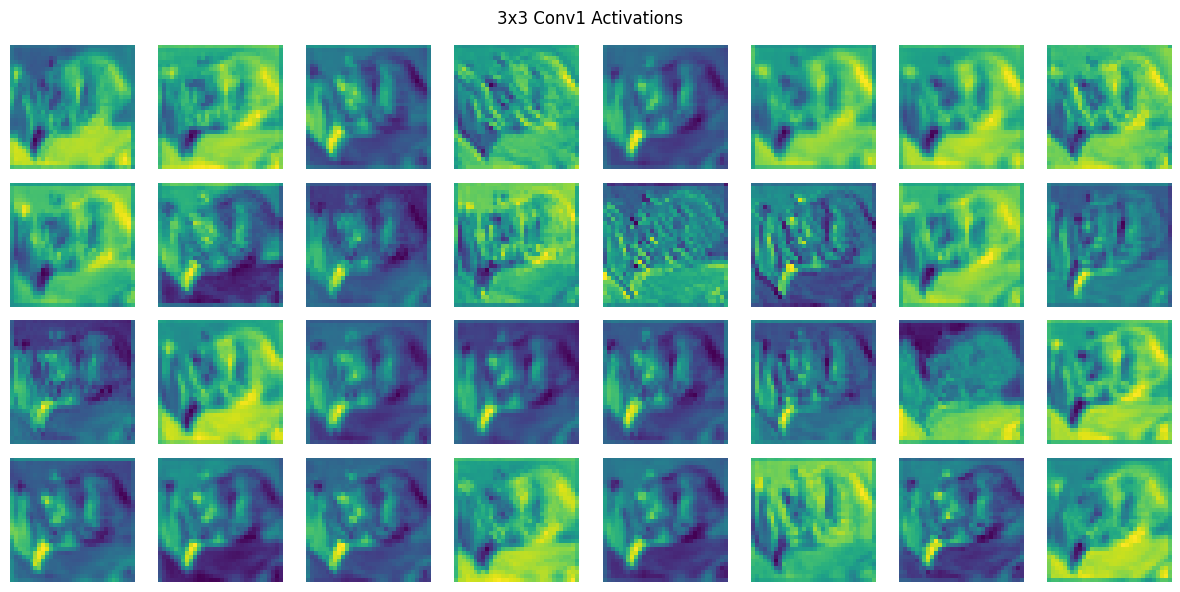

=== Обучение модели с параметрами 5x5 ===
** Рецептивное поле: 16x16
** Количество параметров: 1,105,098

Epoch 1/15   |   Loss: 1.9360   |   Accuracy: 34.48%
Epoch 2/15   |   Loss: 1.7718   |   Accuracy: 38.38%
Epoch 3/15   |   Loss: 1.7176   |   Accuracy: 39.75%
Epoch 4/15   |   Loss: 1.6956   |   Accuracy: 41.07%
Epoch 5/15   |   Loss: 1.6728   |   Accuracy: 41.31%
Epoch 6/15   |   Loss: 1.6478   |   Accuracy: 43.05%
Epoch 7/15   |   Loss: 1.6258   |   Accuracy: 42.60%
Epoch 8/15   |   Loss: 1.6506   |   Accuracy: 42.41%
Epoch 9/15   |   Loss: 1.6006   |   Accuracy: 43.96%
Epoch 10/15   |   Loss: 1.5962   |   Accuracy: 41.75%
Epoch 11/15   |   Loss: 1.5814   |   Accuracy: 43.88%
Epoch 12/15   |   Loss: 1.5876   |   Accuracy: 44.88%
Epoch 13/15   |   Loss: 1.5646   |   Accuracy: 43.37%
Epoch 14/15   |   Loss: 1.5590   |   Accuracy: 44.39%
Epoch 15/15   |   Loss: 1.5651   |   Accuracy: 44.14%


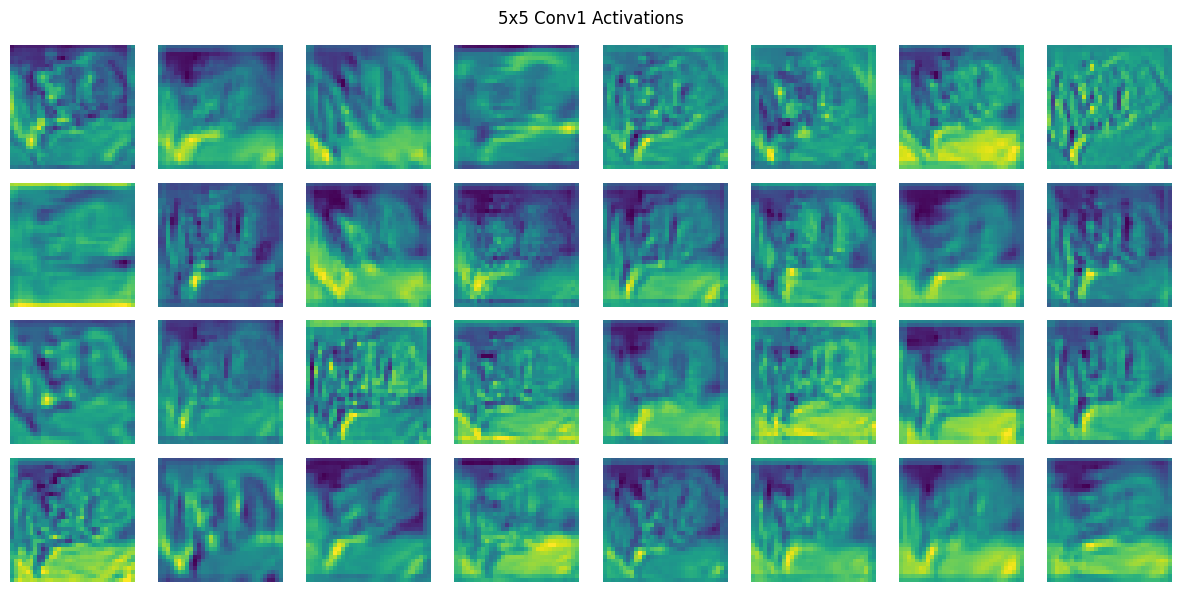

=== Обучение модели с параметрами 7x7 ===
** Рецептивное поле: 22x22
** Количество параметров: 1,156,554

Epoch 1/15   |   Loss: 2.3627   |   Accuracy: 10.00%
Epoch 2/15   |   Loss: 2.3035   |   Accuracy: 10.00%
Epoch 3/15   |   Loss: 2.3036   |   Accuracy: 10.00%
Epoch 4/15   |   Loss: 2.3039   |   Accuracy: 10.00%
Epoch 5/15   |   Loss: 2.3037   |   Accuracy: 10.00%
Epoch 6/15   |   Loss: 2.3034   |   Accuracy: 10.00%
Epoch 7/15   |   Loss: 2.3035   |   Accuracy: 10.00%
Epoch 8/15   |   Loss: 2.3036   |   Accuracy: 10.00%
Epoch 9/15   |   Loss: 2.3037   |   Accuracy: 10.00%
Epoch 10/15   |   Loss: 2.3036   |   Accuracy: 10.00%
Epoch 11/15   |   Loss: 2.3037   |   Accuracy: 10.00%
Epoch 12/15   |   Loss: 2.3034   |   Accuracy: 10.00%
Epoch 13/15   |   Loss: 2.3038   |   Accuracy: 10.00%
Epoch 14/15   |   Loss: 2.3036   |   Accuracy: 10.00%
Epoch 15/15   |   Loss: 2.3035   |   Accuracy: 10.00%


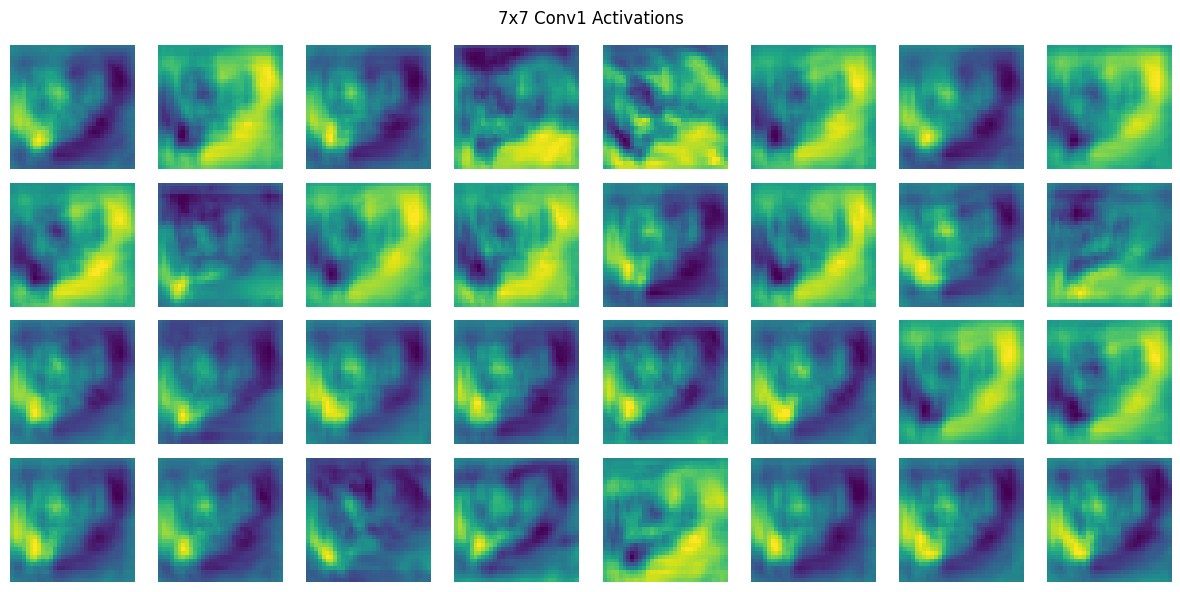

=== Обучение модели с параметрами 1x1 + 3x3 ===
** Рецептивное поле: 10x10
** Количество параметров: 1,070,806

Epoch 1/15   |   Loss: 1.7880   |   Accuracy: 46.09%
Epoch 2/15   |   Loss: 1.5117   |   Accuracy: 49.82%
Epoch 3/15   |   Loss: 1.4466   |   Accuracy: 50.26%
Epoch 4/15   |   Loss: 1.4212   |   Accuracy: 50.49%
Epoch 5/15   |   Loss: 1.3930   |   Accuracy: 49.40%
Epoch 6/15   |   Loss: 1.3806   |   Accuracy: 48.56%
Epoch 7/15   |   Loss: 1.3672   |   Accuracy: 52.41%
Epoch 8/15   |   Loss: 1.3437   |   Accuracy: 50.70%
Epoch 9/15   |   Loss: 1.3457   |   Accuracy: 51.53%
Epoch 10/15   |   Loss: 1.3241   |   Accuracy: 52.07%
Epoch 11/15   |   Loss: 1.3242   |   Accuracy: 53.06%
Epoch 12/15   |   Loss: 1.3080   |   Accuracy: 53.46%
Epoch 13/15   |   Loss: 1.2983   |   Accuracy: 52.40%
Epoch 14/15   |   Loss: 1.3106   |   Accuracy: 53.27%
Epoch 15/15   |   Loss: 1.2947   |   Accuracy: 53.20%


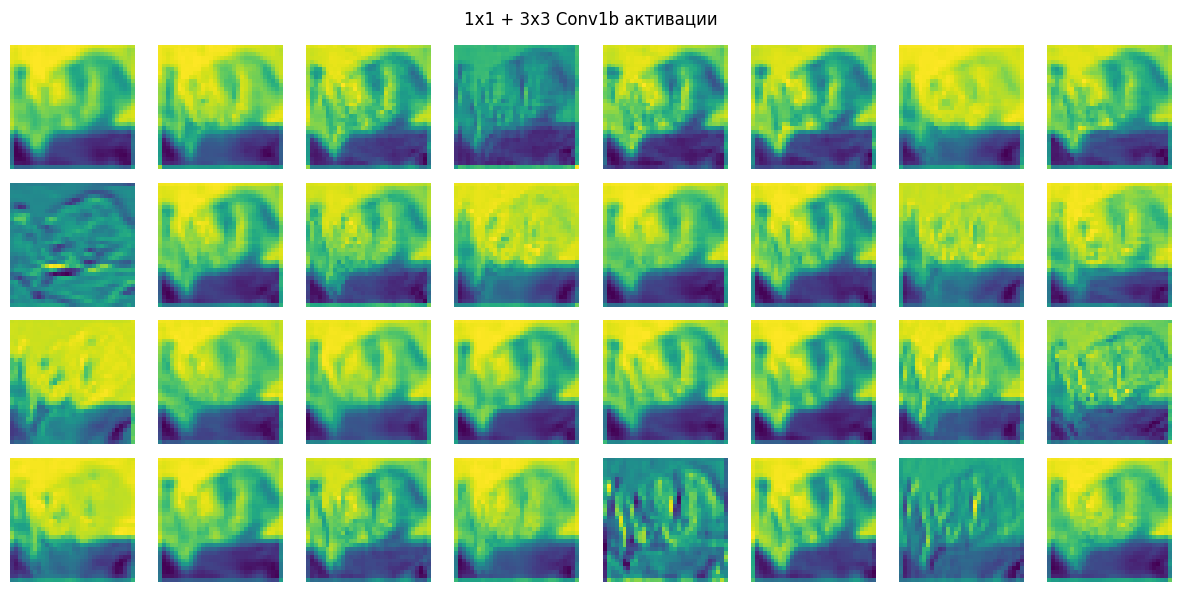

In [10]:
models_config = OrderedDict([
    ("3x3", CIFARCNN(kernel_sizes=(3, 3)).to(device)),
    ("5x5", CIFARCNN(kernel_sizes=(5, 5)).to(device)),
    ("7x7", CIFARCNN(kernel_sizes=(7, 7)).to(device)),
    ("1x1 + 3x3", ComboCIFARCNN().to(device))
])

results = {}

for name, model in models_config.items():
    print(f"=== Обучение модели с параметрами {name} ===")
    
    # Рассчет рецептивного поля
    if name == "1x1 + 3x3":
        rf = calculate_rf((3, 3))  # Для комбинированной модели
    else:
        kernel_size = int(name.split('x')[0])
        rf = calculate_rf((kernel_size, kernel_size))
    
    total_params = sum(p.numel() for p in model.parameters())
    print(f"** Рецептивное поле: {rf}x{rf}")
    print(f"** Количество параметров: {total_params:,}\n")
    
    train_loss, val_acc, time_taken = train_model(model, name)
    
    results[name] = {
        'train_loss': train_loss,
        'val_accuracy': val_acc,
        'training_time': time_taken,
        'receptive_field': rf,
        'parameters': total_params
    }

### Визуализация

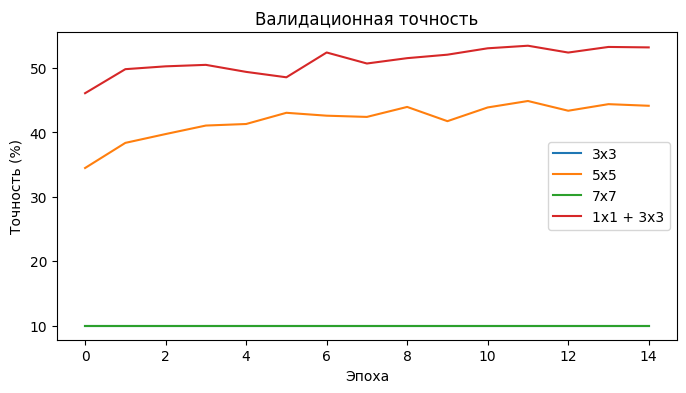

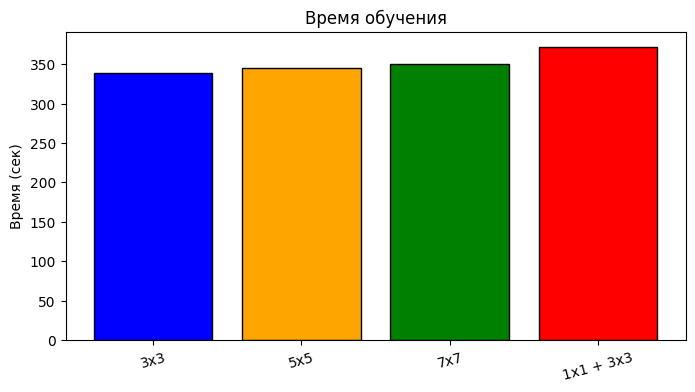

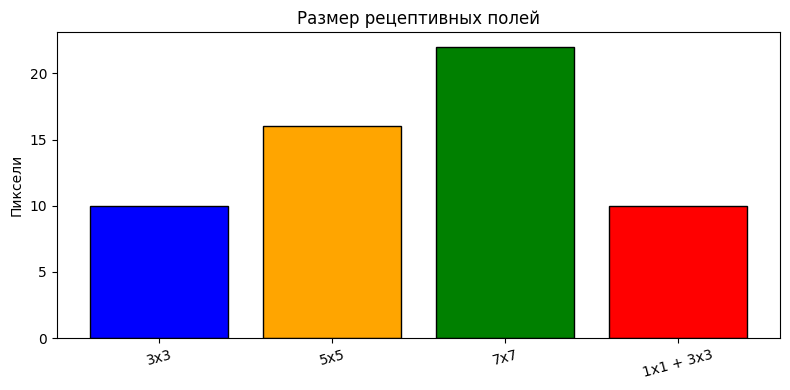

In [22]:
plot_accuracy(results)
plot_train_time(results)
plot_received_field(results)

### Анализ рецептивных полей

Зависимость от размера ядра:

- Ядра большого размера например, 7x7, дают значительно большие рецептивные поля (~68% изображения)
- Малые ядра, как например, 3х3, фокусируются на локальных особенностях (~32%).

Практические последствия:

- Большие рецептивные поля лучше для глобальных признаков
- Малые рецептивные поля сохраняют больше локальных деталей
- Комбинированный подход дает баланс между ними

## 2.2. Влияние глубины CNN

### Импорт библиотек

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms.v2 as v2
import matplotlib.pyplot as plt
import numpy as np
import time
from torch.utils.data import DataLoader
from collections import defaultdict

### Подготовка данных

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 0.001
batch_size = 128

transform = v2.Compose([
    v2.ToTensor(),
    v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
val_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

C:\miniconda\envs\ml\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


### Модели NN

#### Неглубокая CNN (2 слоя)

In [26]:
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

#### Средняя CNN (4 слоя)

In [27]:
class MediumCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 2 * 2, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

#### Глубокая CNN (6 слоев)

In [28]:
class DeepCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

#### CNN с ResidualBlock (взял из репозитория HW4)

In [29]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class CNNWithResidual(nn.Module):
    def __init__(self, input_channels=3, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.res1 = ResidualBlock(32, 32)
        self.res2 = ResidualBlock(32, 64, 2)
        self.res3 = ResidualBlock(64, 64)
        self.pool = nn.AdaptiveAvgPool2d((4, 4))
        self.fc = nn.Linear(64 * 4 * 4, num_classes)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

### Функция обучения модели

In [30]:
def train_and_evaluate(model, train_loader, val_loader, epochs=epochs):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    grad_norms = defaultdict(list)
    
    # Регистрация хуков для градиентов
    hooks = []
    for name, layer in model.named_modules():
        if isinstance(layer, (nn.Conv2d, nn.Linear)):
            def hook_func(module, grad_input, grad_output, name=name):
                if grad_output[0] is not None:
                    grad_norms[name].append(grad_output[0].norm().item())
            hooks.append(layer.register_full_backward_hook(hook_func))
    
    # Метрики
    history = {'train_loss': [], 'train_acc': [], 'val_acc': [], 'time': 0}
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            y_pred = model(inputs)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = y_pred.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                y_pred = model(inputs)
                _, predicted = y_pred.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        val_acc = 100. * val_correct / val_total
        history['val_acc'].append(val_acc)
        
        print(f'Epoch {epoch+1}/{epochs} |   Train Loss: {train_loss:.4f}   |   Train Acc: {train_acc:.2f}%   |   Val Acc: {val_acc:.2f}%')
    
    history['time'] = time.time() - start_time
    for hook in hooks:
        hook.remove()
        
    return history, grad_norms

### Функция для визуализация feature maps

In [34]:
def visualize_feature_maps(model_name, model, val_loader):
    """Функция для визуализации feature maps"""
    model.eval()
    data_iter = iter(val_loader)
    images, _ = next(data_iter)
    image = images[0:1].to(device)
    
    # Регистрация feature maps
    activations = {}
    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook
    
    hooks = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            hooks.append(module.register_forward_hook(get_activation(name)))
    
    with torch.no_grad():
        model(image)
    
    fig, axes = plt.subplots(1, len(activations)+1, figsize=(10, 5))
    orig_image = image[0].cpu().permute(1, 2, 0).numpy()
    orig_image = orig_image * 0.5 + 0.5 # Денормализация
    axes[0].imshow(orig_image)
    axes[0].set_title("Original")
    axes[0].axis('off')
    
    for i, (name, act) in enumerate(activations.items()):
        ax = axes[i+1]
        feature_map = act[0].mean(0).cpu().numpy()
        ax.imshow(feature_map, cmap='viridis')
        ax.set_title(f"{name}\n{act.shape[2]}x{act.shape[3]}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig(f'plots/{model_name}_feature_maps_task_2_2.jpg')
    plt.show()
    
    for hook in hooks:
        hook.remove()

def plot_analys_grads(grad_results):
    """Функция для визуализации средней нормы градиентов по эпохам"""
    plt.figure(figsize=(8, 4))
    for name, norms in grad_results.items():
        avg_norms = [np.mean(values) for values in norms.values()]
        plt.plot(avg_norms, label=name, lw=2)
    
    plt.title('Средняя норма градиентов по эпохам')
    plt.xlabel('Эпоха')
    plt.ylabel('Норма градиента')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.savefig("plots/grads_comparasion_diff_layers_cnn_task_2_2.jpg")
    plt.show()

def plot_accuracy(results):
    """Функция для визуализации метрики точности"""
    plt.figure(figsize=(12, 8)) 
    for name, res in results.items():
        plt.plot(res['epochs'], label=name)
    
    plt.title('Точность на тестовом наборе')
    plt.xlabel('Эпоха')
    plt.ylabel('Точность (%)')
    plt.legend()
    plt.grid(True)
    plt.savefig("plots/accuracy_comparision_diff_layers_cnn_task_2_2.jpg")
    plt.show()

### Обучение моделей


=== Обучение модели Small (2 слоя) ===
Epoch 1/15 |   Train Loss: 1.4362   |   Train Acc: 47.99%   |   Val Acc: 59.86%
Epoch 2/15 |   Train Loss: 1.0860   |   Train Acc: 61.47%   |   Val Acc: 62.76%
Epoch 3/15 |   Train Loss: 0.9295   |   Train Acc: 67.08%   |   Val Acc: 68.17%
Epoch 4/15 |   Train Loss: 0.8187   |   Train Acc: 71.27%   |   Val Acc: 71.19%
Epoch 5/15 |   Train Loss: 0.7315   |   Train Acc: 74.34%   |   Val Acc: 71.55%
Epoch 6/15 |   Train Loss: 0.6495   |   Train Acc: 77.01%   |   Val Acc: 71.64%
Epoch 7/15 |   Train Loss: 0.5737   |   Train Acc: 79.49%   |   Val Acc: 73.38%
Epoch 8/15 |   Train Loss: 0.4997   |   Train Acc: 82.23%   |   Val Acc: 73.13%
Epoch 9/15 |   Train Loss: 0.4388   |   Train Acc: 84.27%   |   Val Acc: 73.04%
Epoch 10/15 |   Train Loss: 0.3801   |   Train Acc: 86.49%   |   Val Acc: 73.18%
Epoch 11/15 |   Train Loss: 0.3358   |   Train Acc: 88.06%   |   Val Acc: 73.29%
Epoch 12/15 |   Train Loss: 0.2897   |   Train Acc: 89.62%   |   Val Acc: 73.5

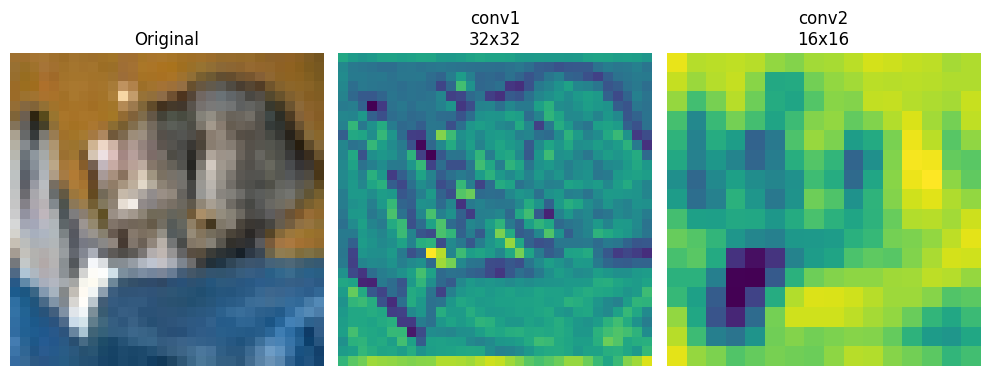


=== Обучение модели Medium (4 слоя) ===
Epoch 1/15 |   Train Loss: 1.5680   |   Train Acc: 41.73%   |   Val Acc: 54.58%
Epoch 2/15 |   Train Loss: 1.1434   |   Train Acc: 58.80%   |   Val Acc: 65.13%
Epoch 3/15 |   Train Loss: 0.9122   |   Train Acc: 67.63%   |   Val Acc: 67.36%
Epoch 4/15 |   Train Loss: 0.7688   |   Train Acc: 72.99%   |   Val Acc: 72.51%
Epoch 5/15 |   Train Loss: 0.6457   |   Train Acc: 77.29%   |   Val Acc: 75.10%
Epoch 6/15 |   Train Loss: 0.5491   |   Train Acc: 80.74%   |   Val Acc: 74.22%
Epoch 7/15 |   Train Loss: 0.4579   |   Train Acc: 83.92%   |   Val Acc: 76.07%
Epoch 8/15 |   Train Loss: 0.3831   |   Train Acc: 86.73%   |   Val Acc: 76.45%
Epoch 9/15 |   Train Loss: 0.3115   |   Train Acc: 88.81%   |   Val Acc: 77.12%
Epoch 10/15 |   Train Loss: 0.2540   |   Train Acc: 90.93%   |   Val Acc: 76.99%
Epoch 11/15 |   Train Loss: 0.2025   |   Train Acc: 92.77%   |   Val Acc: 77.16%
Epoch 12/15 |   Train Loss: 0.1606   |   Train Acc: 94.31%   |   Val Acc: 76.

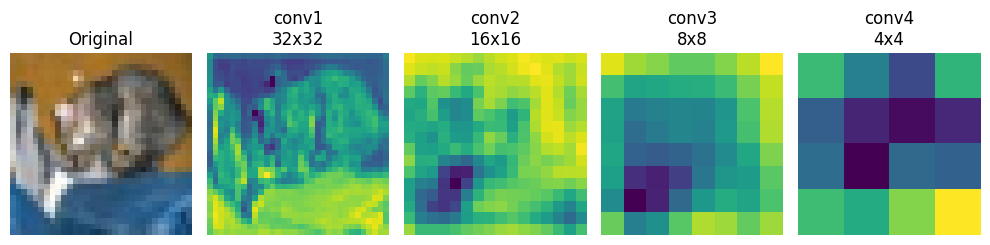


=== Обучение модели Deep (6 слоев) ===
Epoch 1/15 |   Train Loss: 1.6935   |   Train Acc: 37.16%   |   Val Acc: 51.36%
Epoch 2/15 |   Train Loss: 1.1953   |   Train Acc: 56.80%   |   Val Acc: 62.64%
Epoch 3/15 |   Train Loss: 0.9745   |   Train Acc: 65.51%   |   Val Acc: 69.30%
Epoch 4/15 |   Train Loss: 0.8240   |   Train Acc: 70.77%   |   Val Acc: 72.43%
Epoch 5/15 |   Train Loss: 0.7273   |   Train Acc: 74.27%   |   Val Acc: 74.42%
Epoch 6/15 |   Train Loss: 0.6318   |   Train Acc: 77.98%   |   Val Acc: 75.77%
Epoch 7/15 |   Train Loss: 0.5682   |   Train Acc: 80.15%   |   Val Acc: 75.93%
Epoch 8/15 |   Train Loss: 0.5064   |   Train Acc: 82.07%   |   Val Acc: 77.52%
Epoch 9/15 |   Train Loss: 0.4519   |   Train Acc: 84.02%   |   Val Acc: 78.29%
Epoch 10/15 |   Train Loss: 0.3990   |   Train Acc: 85.84%   |   Val Acc: 77.77%
Epoch 11/15 |   Train Loss: 0.3530   |   Train Acc: 87.34%   |   Val Acc: 78.46%
Epoch 12/15 |   Train Loss: 0.3108   |   Train Acc: 88.85%   |   Val Acc: 78.7

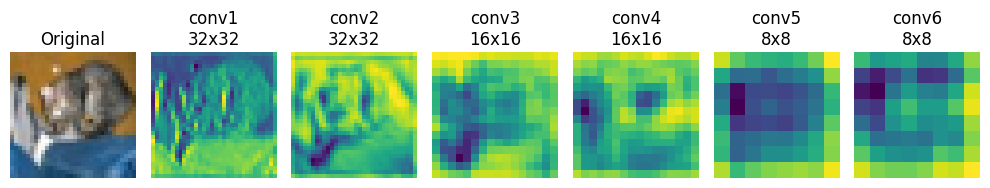


=== Обучение модели CNNWithResidual ===
Epoch 1/15 |   Train Loss: 1.2087   |   Train Acc: 56.27%   |   Val Acc: 62.43%
Epoch 2/15 |   Train Loss: 0.8213   |   Train Acc: 71.28%   |   Val Acc: 73.34%
Epoch 3/15 |   Train Loss: 0.6886   |   Train Acc: 75.83%   |   Val Acc: 74.80%
Epoch 4/15 |   Train Loss: 0.6032   |   Train Acc: 78.82%   |   Val Acc: 75.47%
Epoch 5/15 |   Train Loss: 0.5337   |   Train Acc: 81.32%   |   Val Acc: 77.74%
Epoch 6/15 |   Train Loss: 0.4743   |   Train Acc: 83.56%   |   Val Acc: 79.75%
Epoch 7/15 |   Train Loss: 0.4279   |   Train Acc: 85.35%   |   Val Acc: 77.92%
Epoch 8/15 |   Train Loss: 0.3903   |   Train Acc: 86.42%   |   Val Acc: 80.81%
Epoch 9/15 |   Train Loss: 0.3481   |   Train Acc: 88.21%   |   Val Acc: 79.71%
Epoch 10/15 |   Train Loss: 0.3144   |   Train Acc: 88.97%   |   Val Acc: 81.62%
Epoch 11/15 |   Train Loss: 0.2787   |   Train Acc: 90.41%   |   Val Acc: 80.70%
Epoch 12/15 |   Train Loss: 0.2479   |   Train Acc: 91.41%   |   Val Acc: 81.

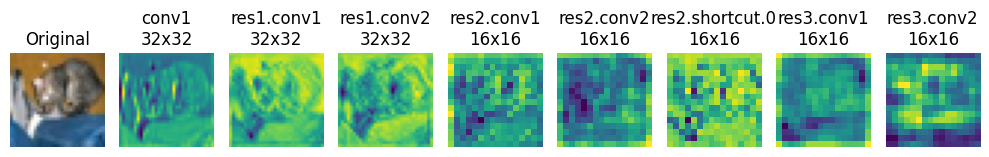

In [35]:
models = {
    "Small (2 слоя)": SmallCNN(),
    "Medium (4 слоя)": MediumCNN(),
    "Deep (6 слоев)": DeepCNN(),
    "CNNWithResidual": CNNWithResidual()
}

results = {}
grad_results = {}

for name, model in models.items():
    print(f"\n=== Обучение модели {name} ===")
    
    history, grad_norms = train_and_evaluate(model, train_loader, val_loader)
    results[name] = {
        'val_accuracy': history['val_acc'][-1],
        'time': history['time'],
        'epochs': history['val_acc']
    }
    grad_results[name] = grad_norms
    
    # Визуализация feature maps
    visualize_feature_maps(name, model, val_loader)

### Анализ результатов

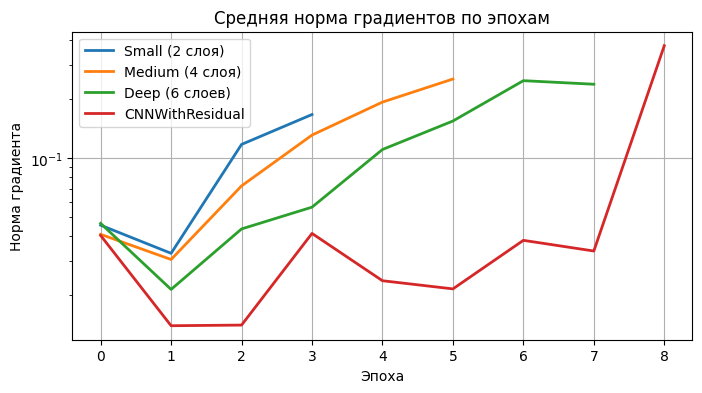

=== Результаты эксперимента: ===
Модель               Точность (%)    Время (с)      
Small (2 слоя)       73.47           364.17         
Medium (4 слоя)      76.79           387.59         
Deep (6 слоев)       78.40           402.71         
CNNWithResidual      81.06           397.16         


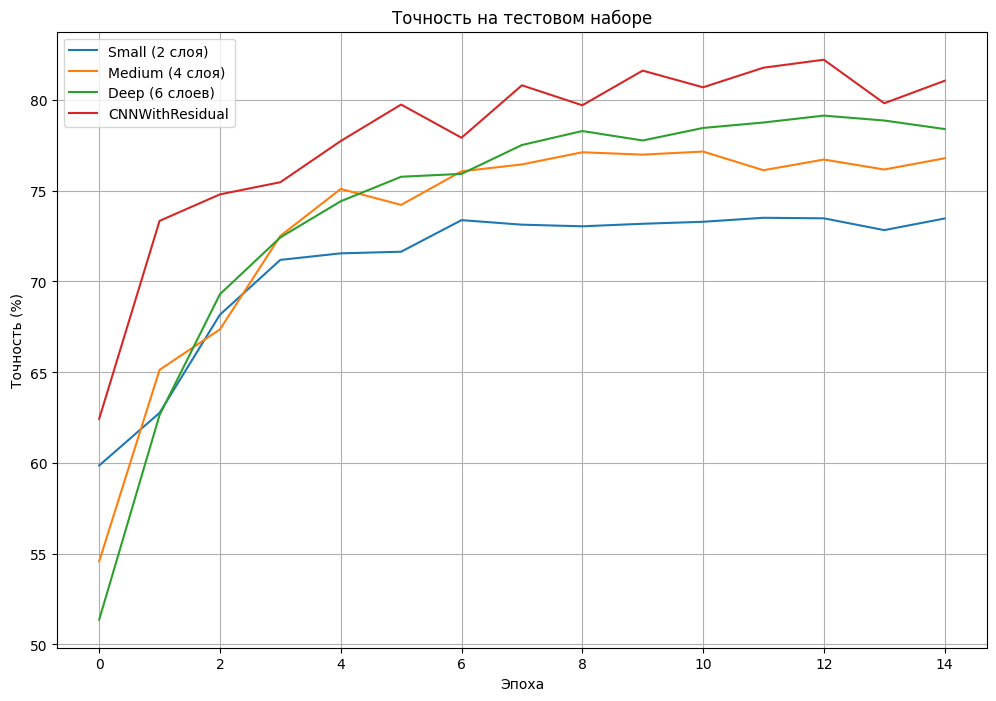

In [37]:
# Анализ градиентов
plot_analys_grads(grad_results)

print("=== Результаты эксперимента: ===")
print(f"{'Модель':<20} {'Точность (%)':<15} {'Время (с)':<15}")
for name, res in results.items():
    print(f"{name:<20} {res['val_accuracy']:<15.2f} {res['time']:<15.2f}")

# График точности
plot_accuracy(results)

Вывод: модель с Residual блоками оказалась самой эффективной по точности.